# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib

# %% Own modules
import models as lm
importlib.reload(lm)

<module 'models' from 'f:\\CPShub\\Tutorial\\Task2_Group Xin and Huasen\\train\\Task1 2\\models.py'>

### 1.1 Data import 

In [14]:
import numpy as np


data_biaxial = np.loadtxt('../../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

# 检查数据
print("Biaxial F:", F_biaxial.shape)
print("Biaxial P:", P_biaxial.shape)
print("Biaxial W:", W_biaxial.shape)

print("Pure Shear F:", F_pure_shear.shape)
print("Pure Shear P:", P_pure_shear.shape)
print("Pure Shear W:", W_pure_shear.shape)

print("Uniaxial F:", F_uniaxial.shape)
print("Uniaxial P:", P_uniaxial.shape)
print("Uniaxial W:", W_uniaxial.shape)


Biaxial F: (199, 3, 3)
Biaxial P: (199, 3, 3)
Biaxial W: (199,)
Pure Shear F: (250, 3, 3)
Pure Shear P: (250, 3, 3)
Pure Shear W: (250,)
Uniaxial F: (199, 3, 3)
Uniaxial P: (199, 3, 3)
Uniaxial W: (199,)


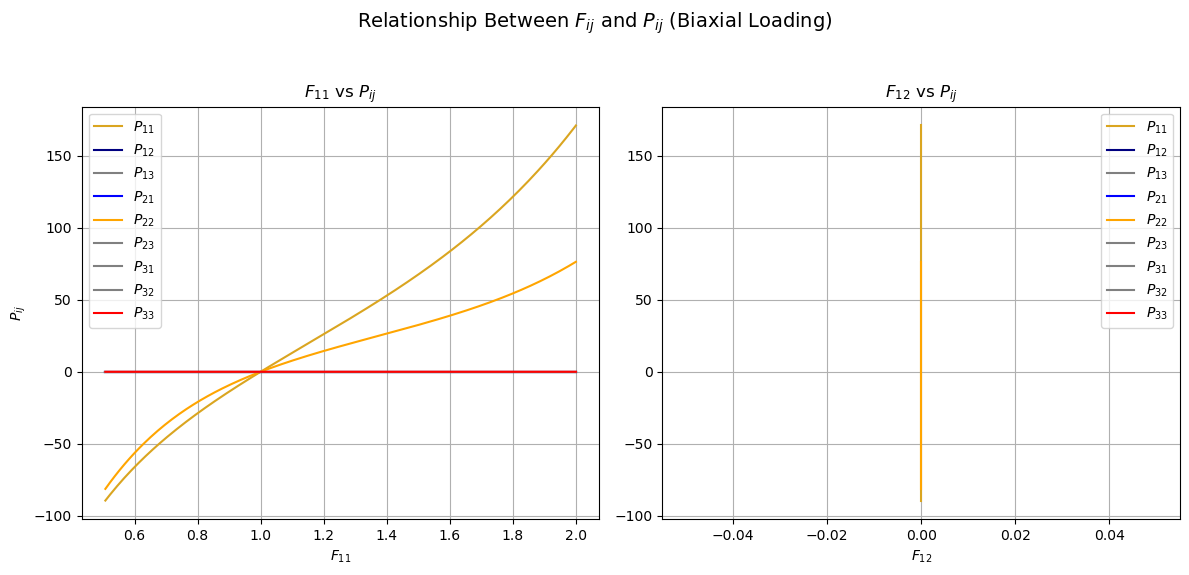

In [15]:
import numpy as np
import matplotlib.pyplot as plt

F11_biaxial = F_biaxial[:, 0, 0]
F12_biaxial = F_biaxial[:, 0, 1]
# 提取Pij分量
P11_biaxial, P12_biaxial, P13_biaxial = P_biaxial[:, 0, 0], P_biaxial[:, 0, 1], P_biaxial[:, 0, 2]
P21_biaxial, P22_biaxial, P23_biaxial = P_biaxial[:, 1, 0], P_biaxial[:, 1, 1], P_biaxial[:, 1, 2]
P31_biaxial, P32_biaxial, P33_biaxial = P_biaxial[:, 2, 0], P_biaxial[:, 2, 1], P_biaxial[:, 2, 2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Relationship Between $F_{ij}$ and $P_{ij}$ (Biaxial Loading)", fontsize=14)

# 绘制 F11 和 Pij
axes[0].plot(F11_biaxial, P11_biaxial, label="$P_{11}$", color='goldenrod')
axes[0].plot(F11_biaxial, P12_biaxial, label="$P_{12}$", color='navy')
axes[0].plot(F11_biaxial, P13_biaxial, label="$P_{13}$", color='gray')
axes[0].plot(F11_biaxial, P21_biaxial, label="$P_{21}$", color='blue')
axes[0].plot(F11_biaxial, P22_biaxial, label="$P_{22}$", color='orange')
axes[0].plot(F11_biaxial, P23_biaxial, label="$P_{23}$", color='gray')
axes[0].plot(F11_biaxial, P31_biaxial, label="$P_{31}$", color='gray')
axes[0].plot(F11_biaxial, P32_biaxial, label="$P_{32}$", color='gray')
axes[0].plot(F11_biaxial, P33_biaxial, label="$P_{33}$", color='red')

axes[0].set_title("$F_{11}$ vs $P_{ij}$")
axes[0].set_xlabel("$F_{11}$")
axes[0].set_ylabel("$P_{ij}$")
axes[0].legend()
axes[0].grid()

# 绘制 F12 和 Pij
axes[1].plot(F12_biaxial, P11_biaxial, label="$P_{11}$", color='goldenrod')
axes[1].plot(F12_biaxial, P12_biaxial, label="$P_{12}$", color='navy')
axes[1].plot(F12_biaxial, P13_biaxial, label="$P_{13}$", color='gray')
axes[1].plot(F12_biaxial, P21_biaxial, label="$P_{21}$", color='blue')
axes[1].plot(F12_biaxial, P22_biaxial, label="$P_{22}$", color='orange')
axes[1].plot(F12_biaxial, P23_biaxial, label="$P_{23}$", color='gray')
axes[1].plot(F12_biaxial, P31_biaxial, label="$P_{31}$", color='gray')
axes[1].plot(F12_biaxial, P32_biaxial, label="$P_{32}$", color='gray')
axes[1].plot(F12_biaxial, P33_biaxial, label="$P_{33}$", color='red')
axes[1].set_title("$F_{12}$ vs $P_{ij}$")
axes[1].set_xlabel("$F_{12}$")
axes[1].legend()
axes[1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


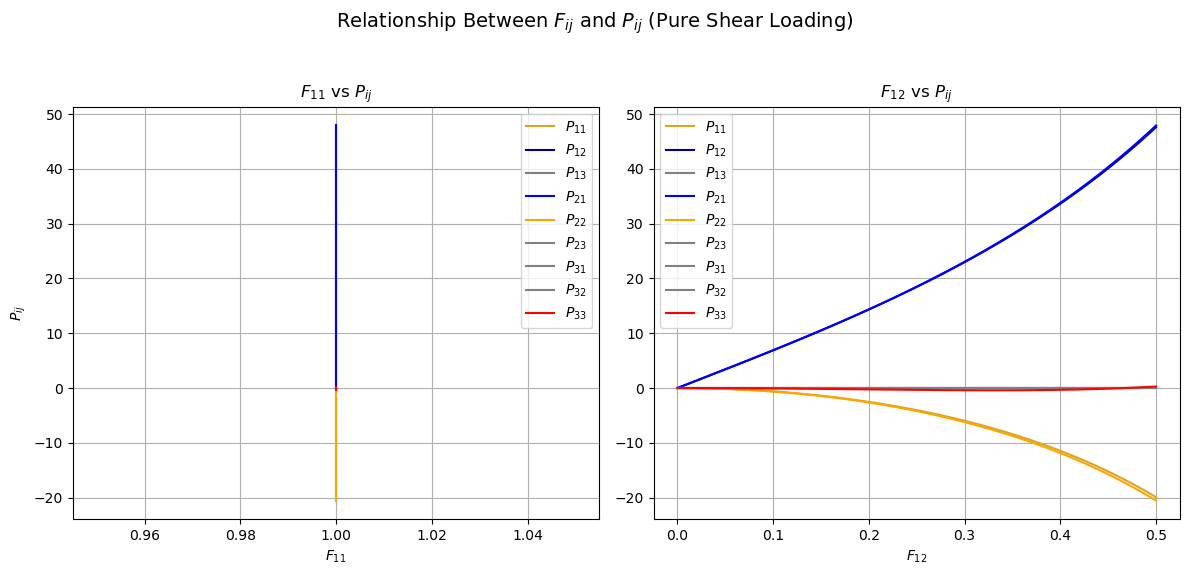

In [16]:
import numpy as np
import matplotlib.pyplot as plt

F11_pure_shear = F_pure_shear[:, 0, 0]
F12_pure_shear = F_pure_shear[:, 0, 1]
# 提取Pij分量
P11_pure_shear, P12_pure_shear, P13_pure_shear = P_pure_shear[:, 0, 0], P_pure_shear[:, 0, 1], P_pure_shear[:, 0, 2]
P21_pure_shear, P22_pure_shear, P23_pure_shear = P_pure_shear[:, 1, 0], P_pure_shear[:, 1, 1], P_pure_shear[:, 1, 2]
P31_pure_shear, P32_pure_shear, P33_pure_shear = P_pure_shear[:, 2, 0], P_pure_shear[:, 2, 1], P_pure_shear[:, 2, 2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Relationship Between $F_{ij}$ and $P_{ij}$ (Pure Shear Loading)", fontsize=14)


# 绘制 F11 和 Pij
axes[0].plot(F11_pure_shear, P11_pure_shear, label="$P_{11}$", color='goldenrod')

axes[0].plot(F11_pure_shear, P12_pure_shear, label="$P_{12}$", color='navy')
axes[0].plot(F11_pure_shear, P13_pure_shear, label="$P_{13}$", color='gray')
axes[0].plot(F11_pure_shear, P21_pure_shear, label="$P_{21}$", color='blue')
axes[0].plot(F11_pure_shear, P22_pure_shear, label="$P_{22}$", color='orange')
axes[0].plot(F11_pure_shear, P23_pure_shear, label="$P_{23}$", color='gray')
axes[0].plot(F11_pure_shear, P31_pure_shear, label="$P_{31}$", color='gray')
axes[0].plot(F11_pure_shear, P32_pure_shear, label="$P_{32}$", color='gray')
axes[0].plot(F11_pure_shear, P33_pure_shear, label="$P_{33}$", color='red')

axes[0].set_title("$F_{11}$ vs $P_{ij}$")
axes[0].set_xlabel("$F_{11}$")
axes[0].set_ylabel("$P_{ij}$")
axes[0].legend()
axes[0].grid()

# 绘制 F12 和 Pij
axes[1].plot(F12_pure_shear, P11_pure_shear, label="$P_{11}$", color='goldenrod')
axes[1].plot(F12_pure_shear, P12_pure_shear, label="$P_{12}$", color='navy')
axes[1].plot(F12_pure_shear, P13_pure_shear, label="$P_{13}$", color='gray')
axes[1].plot(F12_pure_shear, P21_pure_shear, label="$P_{21}$", color='blue')
axes[1].plot(F12_pure_shear, P22_pure_shear, label="$P_{22}$", color='orange')
axes[1].plot(F12_pure_shear, P23_pure_shear, label="$P_{23}$", color='gray')
axes[1].plot(F12_pure_shear, P31_pure_shear, label="$P_{31}$", color='gray')
axes[1].plot(F12_pure_shear, P32_pure_shear, label="$P_{32}$", color='gray')
axes[1].plot(F12_pure_shear, P33_pure_shear, label="$P_{33}$", color='red')
axes[1].set_title("$F_{12}$ vs $P_{ij}$")
axes[1].set_xlabel("$F_{12}$")
axes[1].legend()
axes[1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


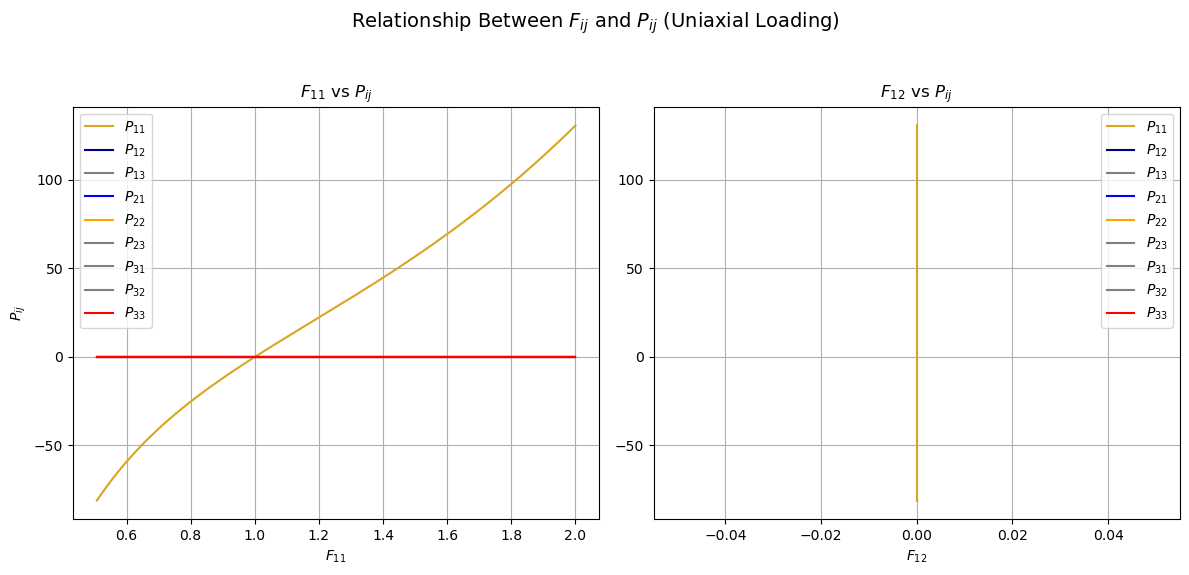

In [17]:
import numpy as np
import matplotlib.pyplot as plt

F11_uniaxial = F_uniaxial[:, 0, 0]
F12_uniaxial = F_uniaxial[:, 0, 1]
# 提取Pij分量
P11_uniaxial, P12_uniaxial, P13_uniaxial = P_uniaxial[:, 0, 0], P_uniaxial[:, 0, 1], P_uniaxial[:, 0, 2]
P21_uniaxial, P22_uniaxial, P23_uniaxial = P_uniaxial[:, 1, 0], P_uniaxial[:, 1, 1], P_uniaxial[:, 1, 2]
P31_uniaxial, P32_uniaxial, P33_uniaxial = P_uniaxial[:, 2, 0], P_uniaxial[:, 2, 1], P_uniaxial[:, 2, 2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Relationship Between $F_{ij}$ and $P_{ij}$ (Uniaxial Loading)", fontsize=14)

# 绘制 F11 和 Pij
axes[0].plot(F11_uniaxial, P11_uniaxial, label="$P_{11}$", color='goldenrod')
axes[0].plot(F11_uniaxial, P12_uniaxial, label="$P_{12}$", color='navy')
axes[0].plot(F11_uniaxial, P13_uniaxial, label="$P_{13}$", color='gray')
axes[0].plot(F11_uniaxial, P21_uniaxial, label="$P_{21}$", color='blue')
axes[0].plot(F11_uniaxial, P22_uniaxial, label="$P_{22}$", color='orange')
axes[0].plot(F11_uniaxial, P23_uniaxial, label="$P_{23}$", color='gray')
axes[0].plot(F11_uniaxial, P31_uniaxial, label="$P_{31}$", color='gray')
axes[0].plot(F11_uniaxial, P32_uniaxial, label="$P_{32}$", color='gray')
axes[0].plot(F11_uniaxial, P33_uniaxial, label="$P_{33}$", color='red')

axes[0].set_title("$F_{11}$ vs $P_{ij}$")
axes[0].set_xlabel("$F_{11}$")
axes[0].set_ylabel("$P_{ij}$")
axes[0].legend()
axes[0].grid()

# 绘制 F12 和 Pij
axes[1].plot(F12_uniaxial, P11_uniaxial, label="$P_{11}$", color='goldenrod')
axes[1].plot(F12_uniaxial, P12_uniaxial, label="$P_{12}$", color='navy')
axes[1].plot(F12_uniaxial, P13_uniaxial, label="$P_{13}$", color='gray')
axes[1].plot(F12_uniaxial, P21_uniaxial, label="$P_{21}$", color='blue')
axes[1].plot(F12_uniaxial, P22_uniaxial, label="$P_{22}$", color='orange')
axes[1].plot(F12_uniaxial, P23_uniaxial, label="$P_{23}$", color='gray')
axes[1].plot(F12_uniaxial, P31_uniaxial, label="$P_{31}$", color='gray')
axes[1].plot(F12_uniaxial, P32_uniaxial, label="$P_{32}$", color='gray')
axes[1].plot(F12_uniaxial, P33_uniaxial, label="$P_{33}$", color='red')
axes[1].set_title("$F_{12}$ vs $P_{ij}$")
axes[1].set_xlabel("$F_{12}$")
axes[1].legend()
axes[1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
data_biaxial_test = np.loadtxt('../../test/biax_test.txt')
data_mixed_test = np.loadtxt('../../test/mixed_test.txt')

F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)

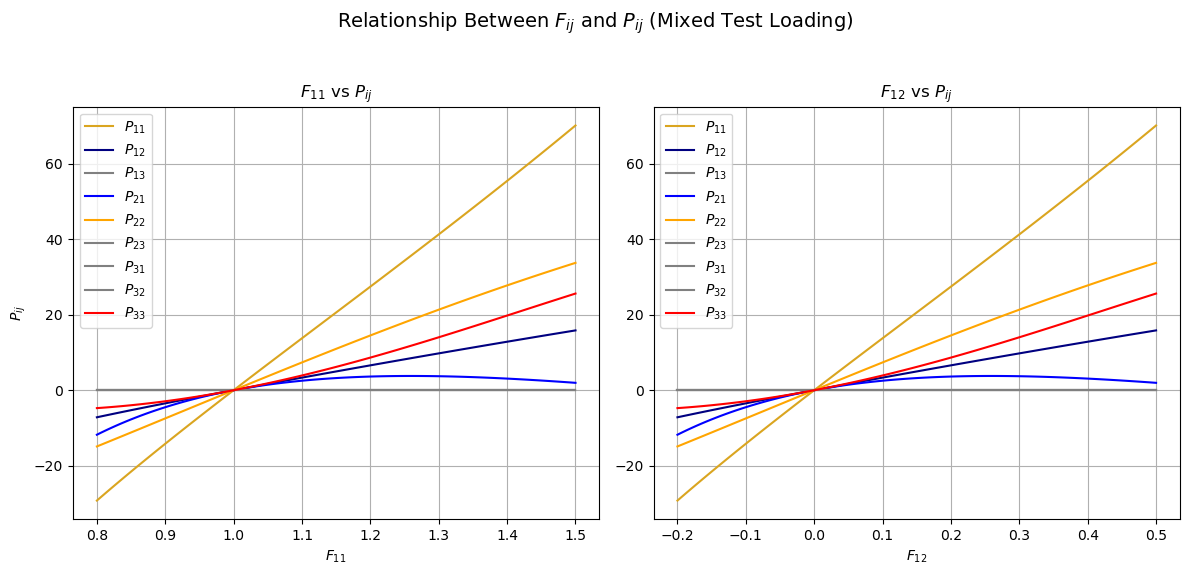

In [19]:
import numpy as np
import matplotlib.pyplot as plt

F11_mixed_test = F_mixed_test[:, 0, 0]
F12_mixed_test = F_mixed_test[:, 0, 1]
# 提取Pij分量
P11_mixed_test, P12_mixed_test, P13_mixed_test = P_mixed_test[:, 0, 0], P_mixed_test[:, 0, 1], P_mixed_test[:, 0, 2]
P21_mixed_test, P22_mixed_test, P23_mixed_test = P_mixed_test[:, 1, 0], P_mixed_test[:, 1, 1], P_mixed_test[:, 1, 2]
P31_mixed_test, P32_mixed_test, P33_mixed_test = P_mixed_test[:, 2, 0], P_mixed_test[:, 2, 1], P_mixed_test[:, 2, 2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Relationship Between $F_{ij}$ and $P_{ij}$ (Mixed Test Loading)", fontsize=14)

# 绘制 F11 和 Pij
axes[0].plot(F11_mixed_test, P11_mixed_test, label="$P_{11}$", color='goldenrod')
axes[0].plot(F11_mixed_test, P12_mixed_test, label="$P_{12}$", color='navy')
axes[0].plot(F11_mixed_test, P13_mixed_test, label="$P_{13}$", color='gray')
axes[0].plot(F11_mixed_test, P21_mixed_test, label="$P_{21}$", color='blue')
axes[0].plot(F11_mixed_test, P22_mixed_test, label="$P_{22}$", color='orange')
axes[0].plot(F11_mixed_test, P23_mixed_test, label="$P_{23}$", color='gray')
axes[0].plot(F11_mixed_test, P31_mixed_test, label="$P_{31}$", color='gray')
axes[0].plot(F11_mixed_test, P32_mixed_test, label="$P_{32}$", color='gray')
axes[0].plot(F11_mixed_test, P33_mixed_test, label="$P_{33}$", color='red')

axes[0].set_title("$F_{11}$ vs $P_{ij}$")
axes[0].set_xlabel("$F_{11}$")
axes[0].set_ylabel("$P_{ij}$")
axes[0].legend()
axes[0].grid()

# 绘制 F12 和 Pij
axes[1].plot(F12_mixed_test, P11_mixed_test, label="$P_{11}$", color='goldenrod')
axes[1].plot(F12_mixed_test, P12_mixed_test, label="$P_{12}$", color='navy')
axes[1].plot(F12_mixed_test, P13_mixed_test, label="$P_{13}$", color='gray')
axes[1].plot(F12_mixed_test, P21_mixed_test, label="$P_{21}$", color='blue')
axes[1].plot(F12_mixed_test, P22_mixed_test, label="$P_{22}$", color='orange')
axes[1].plot(F12_mixed_test, P23_mixed_test, label="$P_{23}$", color='gray')
axes[1].plot(F12_mixed_test, P31_mixed_test, label="$P_{31}$", color='gray')
axes[1].plot(F12_mixed_test, P32_mixed_test, label="$P_{32}$", color='gray')
axes[1].plot(F12_mixed_test, P33_mixed_test, label="$P_{33}$", color='red')
axes[1].set_title("$F_{12}$ vs $P_{ij}$")
axes[1].set_xlabel("$F_{12}$")
axes[1].legend()
axes[1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

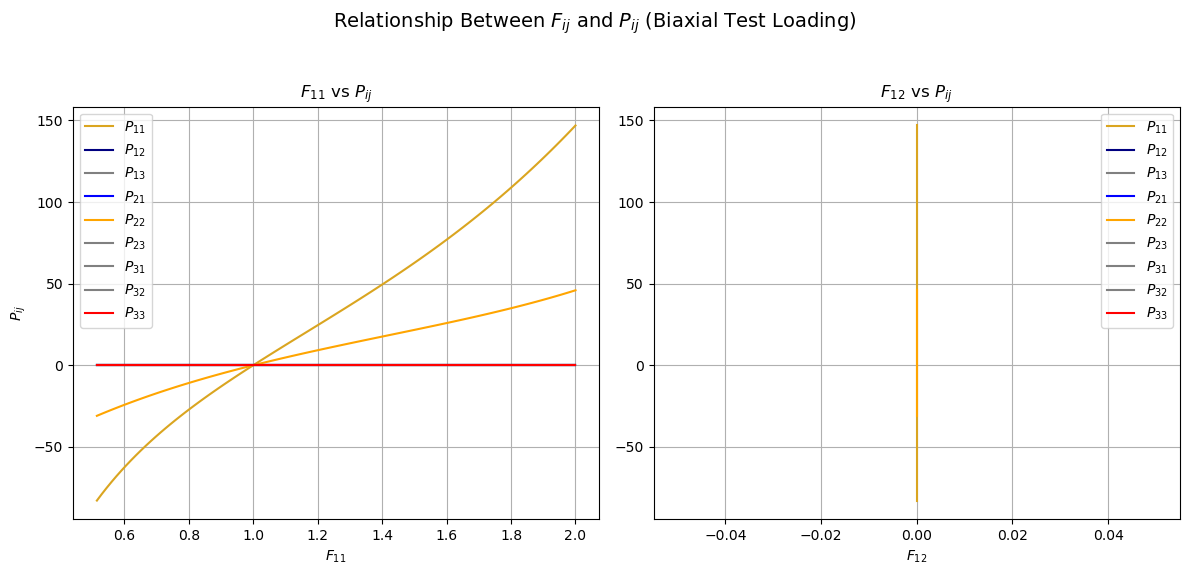

In [20]:
import numpy as np
import matplotlib.pyplot as plt

F11_biaxial_test = F_biaxial_test[:, 0, 0]
F12_biaxial_test = F_biaxial_test[:, 0, 1]
# 提取Pij分量
P11_biaxial_test, P12_biaxial_test, P13_biaxial_test = P_biaxial_test[:, 0, 0], P_biaxial_test[:, 0, 1], P_biaxial_test[:, 0, 2]
P21_biaxial_test, P22_biaxial_test, P23_biaxial_test = P_biaxial_test[:, 1, 0], P_biaxial_test[:, 1, 1], P_biaxial_test[:, 1, 2]
P31_biaxial_test, P32_biaxial_test, P33_biaxial_test = P_biaxial_test[:, 2, 0], P_biaxial_test[:, 2, 1], P_biaxial_test[:, 2, 2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Relationship Between $F_{ij}$ and $P_{ij}$ (Biaxial Test Loading)", fontsize=14)

# 绘制 F11 和 Pij
axes[0].plot(F11_biaxial_test, P11_biaxial_test, label="$P_{11}$", color='goldenrod')
axes[0].plot(F11_biaxial_test, P12_biaxial_test, label="$P_{12}$", color='navy')
axes[0].plot(F11_biaxial_test, P13_biaxial_test, label="$P_{13}$", color='gray')
axes[0].plot(F11_biaxial_test, P21_biaxial_test, label="$P_{21}$", color='blue')
axes[0].plot(F11_biaxial_test, P22_biaxial_test, label="$P_{22}$", color='orange')
axes[0].plot(F11_biaxial_test, P23_biaxial_test, label="$P_{23}$", color='gray')
axes[0].plot(F11_biaxial_test, P31_biaxial_test, label="$P_{31}$", color='gray')
axes[0].plot(F11_biaxial_test, P32_biaxial_test, label="$P_{32}$", color='gray')
axes[0].plot(F11_biaxial_test, P33_biaxial_test, label="$P_{33}$", color='red')

axes[0].set_title("$F_{11}$ vs $P_{ij}$")
axes[0].set_xlabel("$F_{11}$")
axes[0].set_ylabel("$P_{ij}$")
axes[0].legend()
axes[0].grid()

# 绘制 F12 和 Pij
axes[1].plot(F12_biaxial_test, P11_biaxial_test, label="$P_{11}$", color='goldenrod')
axes[1].plot(F12_biaxial_test, P12_biaxial_test, label="$P_{12}$", color='navy')
axes[1].plot(F12_biaxial_test, P13_biaxial_test, label="$P_{13}$", color='gray')
axes[1].plot(F12_biaxial_test, P21_biaxial_test, label="$P_{21}$", color='blue')
axes[1].plot(F12_biaxial_test, P22_biaxial_test, label="$P_{22}$", color='orange')
axes[1].plot(F12_biaxial_test, P23_biaxial_test, label="$P_{23}$", color='gray')
axes[1].plot(F12_biaxial_test, P31_biaxial_test, label="$P_{31}$", color='gray')
axes[1].plot(F12_biaxial_test, P32_biaxial_test, label="$P_{32}$", color='gray')
axes[1].plot(F12_biaxial_test, P33_biaxial_test, label="$P_{33}$", color='red')
axes[1].set_title("$F_{12}$ vs $P_{ij}$")
axes[1].set_xlabel("$F_{12}$")
axes[1].legend()
axes[1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 1.2 Analytical potential

In [4]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [5]:
#@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * tf.math.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [6]:
def process_invariants(data):

    I_1 = data[:, 0]
    J = data[:, 1]
    I_4 = data[:, 2]
    I_5 = data[:, 3]
    return I_1, J, I_4, I_5

In [7]:
I1_biaxial_pred, J_biaxial_pred, I4_biaxial_pred, I5_biaxial_pred = compute_invariants(F_biaxial) 
def check_invariants(pred, data):
    return np.allclose(pred, data, atol=1e-2)
data_biaxial_I = np.loadtxt('../../invariants/I_biaxial.txt')
I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = process_invariants(data_biaxial_I)
print("Biaxial I1 Check:", check_invariants(I1_biaxial_pred, I1_data_biaxial))
print("Biaxial J Check:", check_invariants(J_biaxial_pred, J_data_biaxial))
print("Biaxial I4 Check:", check_invariants(I4_biaxial_pred, I4_data_biaxial))
print("Biaxial I5 Check:", check_invariants(I5_biaxial_pred, I5_data_biaxial))

Biaxial I1 Check: True
Biaxial J Check: True
Biaxial I4 Check: True
Biaxial I5 Check: True


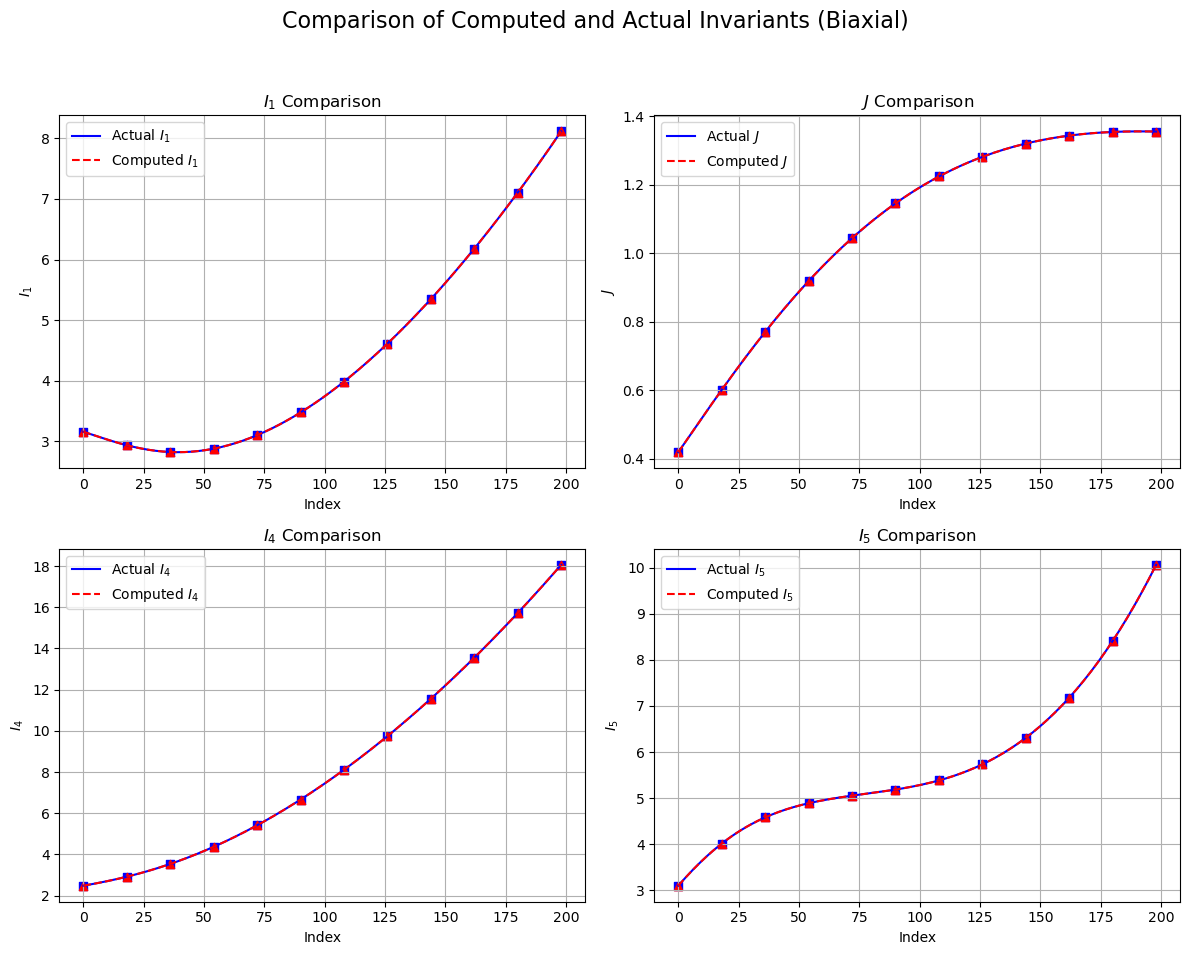

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


I1_biaxial_pred, J_biaxial_pred, I4_biaxial_pred, I5_biaxial_pred = compute_invariants(F_biaxial) 
data_biaxial_I = np.loadtxt('../../invariants/I_biaxial.txt')
I1_data_biaxial, J_data_biaxial, I4_data_biaxial, I5_data_biaxial = process_invariants(data_biaxial_I)

# 将 TensorFlow 张量转换为 NumPy 数组
I1_biaxial_pred = I1_biaxial_pred.numpy()
J_biaxial_pred = J_biaxial_pred.numpy()
I4_biaxial_pred = I4_biaxial_pred.numpy()
I5_biaxial_pred = I5_biaxial_pred.numpy()

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Comparison of Computed and Actual Invariants (Biaxial)", fontsize=16)

# 取12个点进行标记
indices = np.linspace(0, len(I1_data_biaxial) - 1, 12).astype(int)

# 绘制 I1 比较
axes[0, 0].plot(I1_data_biaxial, label='Actual $I_1$', color='blue')
axes[0, 0].plot(I1_biaxial_pred, label='Computed $I_1$', color='red', linestyle='--')
axes[0, 0].scatter(indices, I1_data_biaxial[indices], marker='s', color='blue')
axes[0, 0].scatter(indices, I1_biaxial_pred[indices], marker='^', color='red')
axes[0, 0].set_title("$I_1$ Comparison")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("$I_1$")
axes[0, 0].legend()
axes[0, 0].grid()

# 绘制 J 比较
axes[0, 1].plot(J_data_biaxial, label='Actual $J$', color='blue')
axes[0, 1].plot(J_biaxial_pred, label='Computed $J$', color='red', linestyle='--')
axes[0, 1].scatter(indices, J_data_biaxial[indices], marker='s', color='blue')
axes[0, 1].scatter(indices, J_biaxial_pred[indices], marker='^', color='red')
axes[0, 1].set_title("$J$ Comparison")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("$J$")
axes[0, 1].legend()
axes[0, 1].grid()

# 绘制 I4 比较
axes[1, 0].plot(I4_data_biaxial, label='Actual $I_4$', color='blue')
axes[1, 0].plot(I4_biaxial_pred, label='Computed $I_4$', color='red', linestyle='--')
axes[1, 0].scatter(indices, I4_data_biaxial[indices], marker='s', color='blue')
axes[1, 0].scatter(indices, I4_biaxial_pred[indices], marker='^', color='red')
axes[1, 0].set_title("$I_4$ Comparison")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("$I_4$")
axes[1, 0].legend()
axes[1, 0].grid()

# 绘制 I5 比较
axes[1, 1].plot(I5_data_biaxial, label='Actual $I_5$', color='blue')
axes[1, 1].plot(I5_biaxial_pred, label='Computed $I_5$', color='red', linestyle='--')
axes[1, 1].scatter(indices, I5_data_biaxial[indices], marker='s', color='blue')
axes[1, 1].scatter(indices, I5_biaxial_pred[indices], marker='^', color='red')
axes[1, 1].set_title("$I_5$ Comparison")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("$I_5$")
axes[1, 1].legend()
axes[1, 1].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# 计算应力张量 P
def compute_stress_tensor(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(F)
        
        # 计算不变量 I1, J, I4 和 I5
        I1, J, I4, I5 = compute_invariants(F)
        
        # 计算应变能函数 W
        W = neo_hookean_potential(I1, J, I4, I5)
    
    # 使用自动微分计算应力张量 P = dW/dF
    #print("W shape:", W.shape)
    P = tape.gradient(W, F)
    return P

In [9]:
P_biaxial_compute = compute_stress_tensor(F_biaxial)

In [10]:
print("Biaxial P shape:", P_biaxial_compute.shape)

Biaxial P shape: (199, 3, 3)


In [11]:
print("Biaxial I1 Check:", check_invariants(P_biaxial_compute, P_biaxial))

Biaxial I1 Check: True


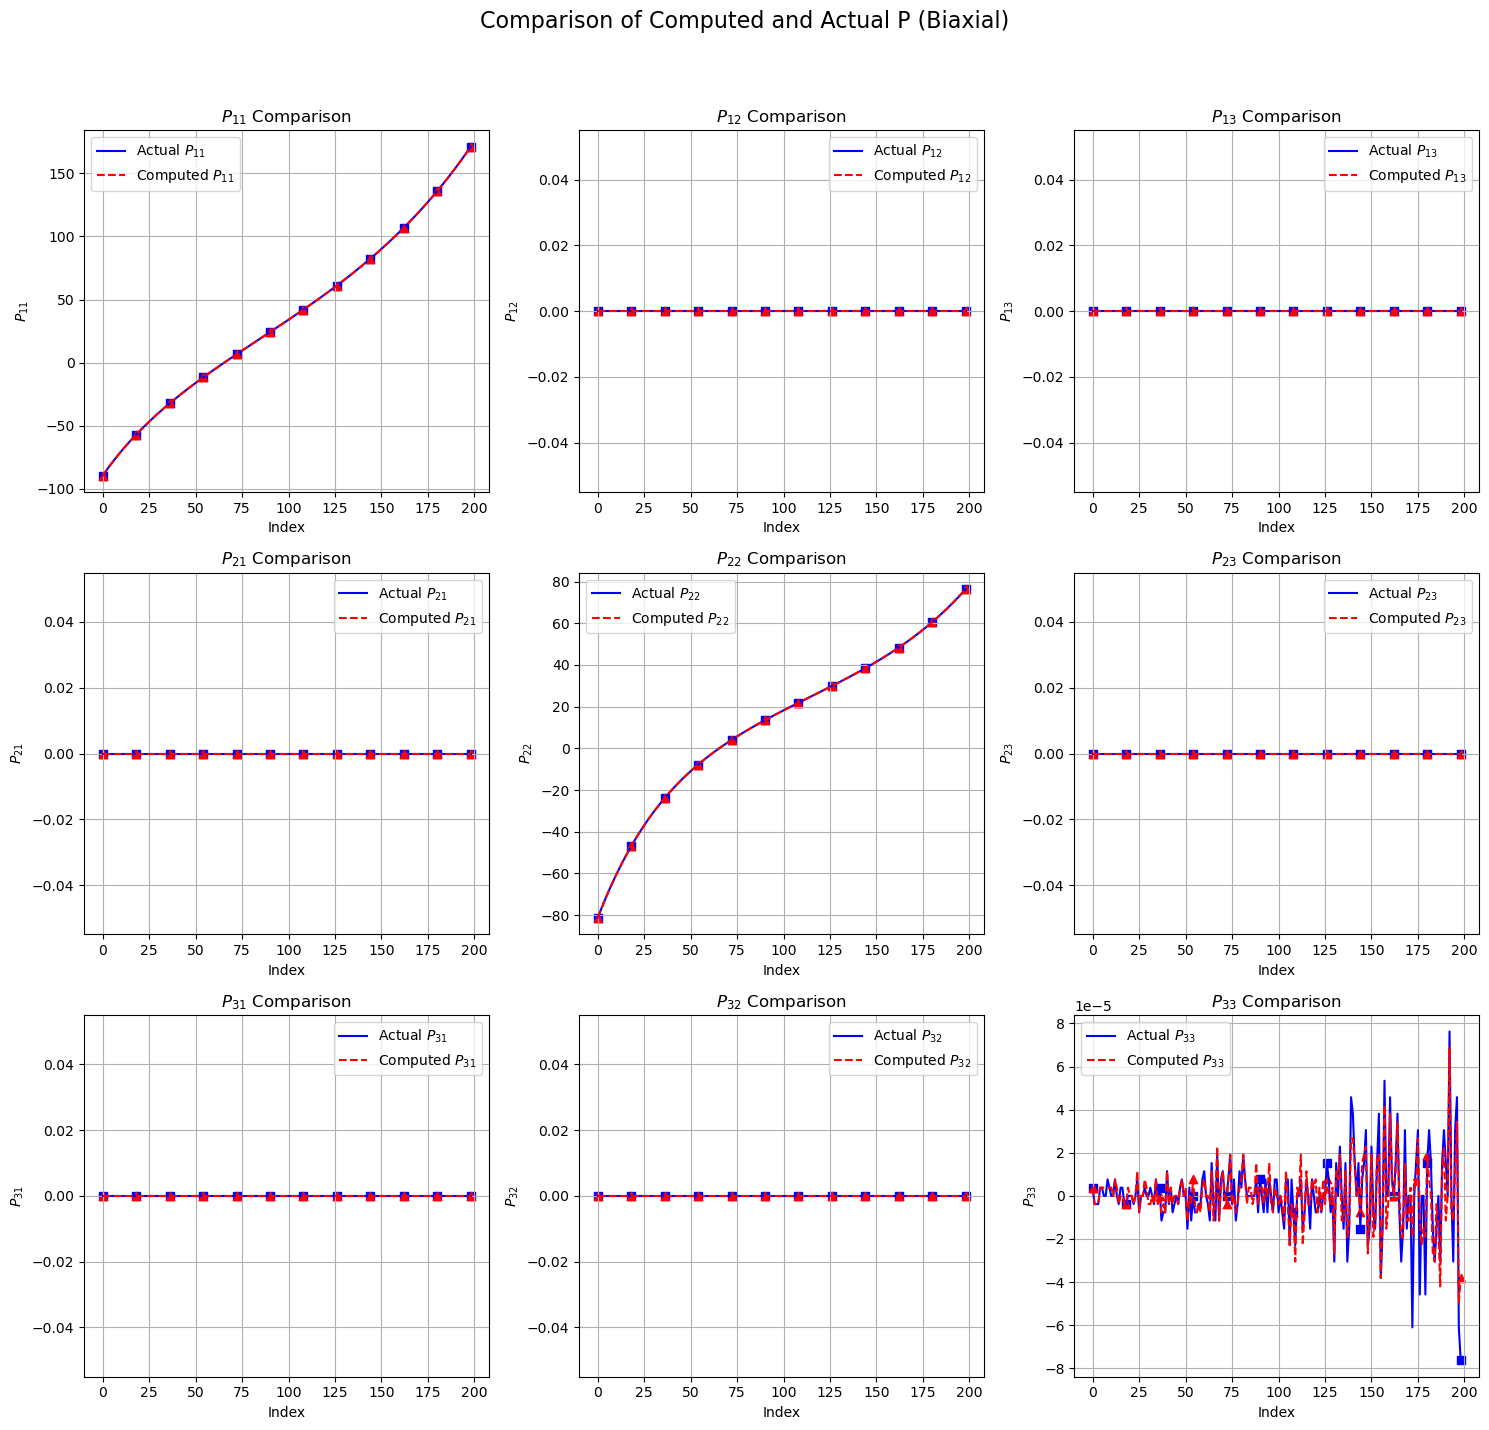

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



# 将 TensorFlow 张量转换为 NumPy 数组
P_biaxial_compute = P_biaxial_compute.numpy()

# 创建子图
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Comparison of Computed and Actual P (Biaxial)", fontsize=16)

# 取12个点进行标记
indices = np.linspace(0, len(P_biaxial) - 1, 12).astype(int)

# 绘制各个 Pij 的比较
for i in range(3):
    for j in range(3):
        axes[i, j].plot(P_biaxial[:, i, j], label=f'Actual $P_{{{i+1}{j+1}}}$', color='blue')
        axes[i, j].plot(P_biaxial_compute[:, i, j], label=f'Computed $P_{{{i+1}{j+1}}}$', color='red', linestyle='--')
        axes[i, j].scatter(indices, P_biaxial[indices, i, j], marker='s', color='blue')
        axes[i, j].scatter(indices, P_biaxial_compute[indices, i, j], marker='^', color='red')
        axes[i, j].set_title(f"$P_{{{i+1}{j+1}}}$ Comparison")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel(f"$P_{{{i+1}{j+1}}}$")
        axes[i, j].legend()
        axes[i, j].grid()

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2.1 Model implementation

In [32]:
import numpy as np

F_train = np.concatenate([F_biaxial.reshape(-1, 9), F_pure_shear.reshape(-1, 9), F_uniaxial.reshape(-1, 9)], axis=0)
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_pure_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)
print(F_train.shape, P_train.shape)

(648, 9) (648, 9)


In [47]:
model1 = lm.main()


model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p_1 (_C_to_P)  (None, 9)                 93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3000
21/21 [==============================] - 0s 1ms/step - loss: 460.0710
Epoch 2/3000
21/21 [==============================] - 0s 1ms/step - loss: 456.4382
Epoch 3/3000
21/21 [==============================] - 0s 1ms/step - loss: 453.2369
Epoch 4/3000
21/21 [==============================] - 0s 1ms/step - loss: 450.3334
Epoch 5/3000
21/21 [==============================] - 0s 1ms/step - loss: 447.6476
Epoch 6/3000
21/21 [==============================] - 0s 1ms/step - loss: 445.1434
Epoch 7/3000
21/21 [==============================] - 0s 1ms/step - loss: 442.7818
Epoch 8/3000
21/21 [==============================] - 0s 1ms/step - loss: 440.4541
Epoch 9/3000
21/21 [==============================] - 0s 1ms/step - loss: 438.0425
Epoch 10/3000
21/21 [==============================] - 0s 1ms/step - loss: 435.3543
Epoch 11/3000
21/21 [==============================] - 0s 1ms/step - loss: 432.5127
Epoch 12/3000
21/21 [==============================] - 0s 1ms/step - loss: 429.3194
E

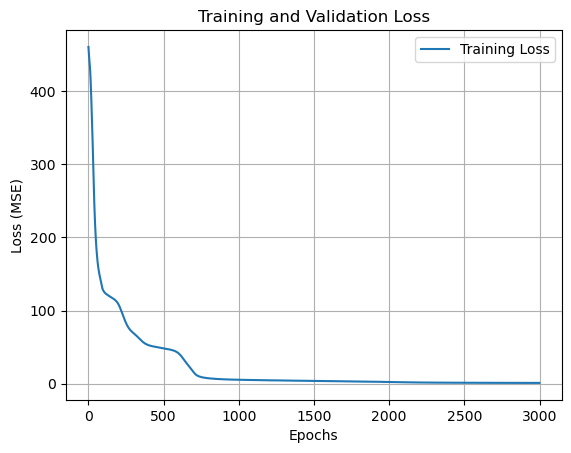

In [48]:
# 训练模型
def convert_F_to_C(F_data):
    # 将 F_data 重塑为 (N, 3, 3) 形状
    F_data = F_data.reshape(-1, 3, 3)
    # 对每个样本计算 C = F^T * F
    C_data = np.einsum('...ji,...jk->...ik', F_data, F_data)
    # 提取对称矩阵 C 的六个独立分量
    C_data_6 = np.stack([C_data[:, 0, 0],  # c11
                         C_data[:, 1, 1],  # c22
                         C_data[:, 2, 2],  # c33
                         C_data[:, 0, 1],  # c12
                         C_data[:, 0, 2],  # c13
                         C_data[:, 1, 2]], axis=-1)  # c23
    return C_data_6

# 转换训练和测试数据
C_train = convert_F_to_C(F_train)



# 模型训练
history = model1.fit(C_train, P_train, epochs=3000)

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [40]:
print(F_biaxial_test.shape, F_mixed_test.shape)

(99, 3, 3) (100, 3, 3)


4/4 [==============================] - 0s 1ms/step


C:\Users\10472\AppData\Local\Temp\ipykernel_29080\4078331636.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^',


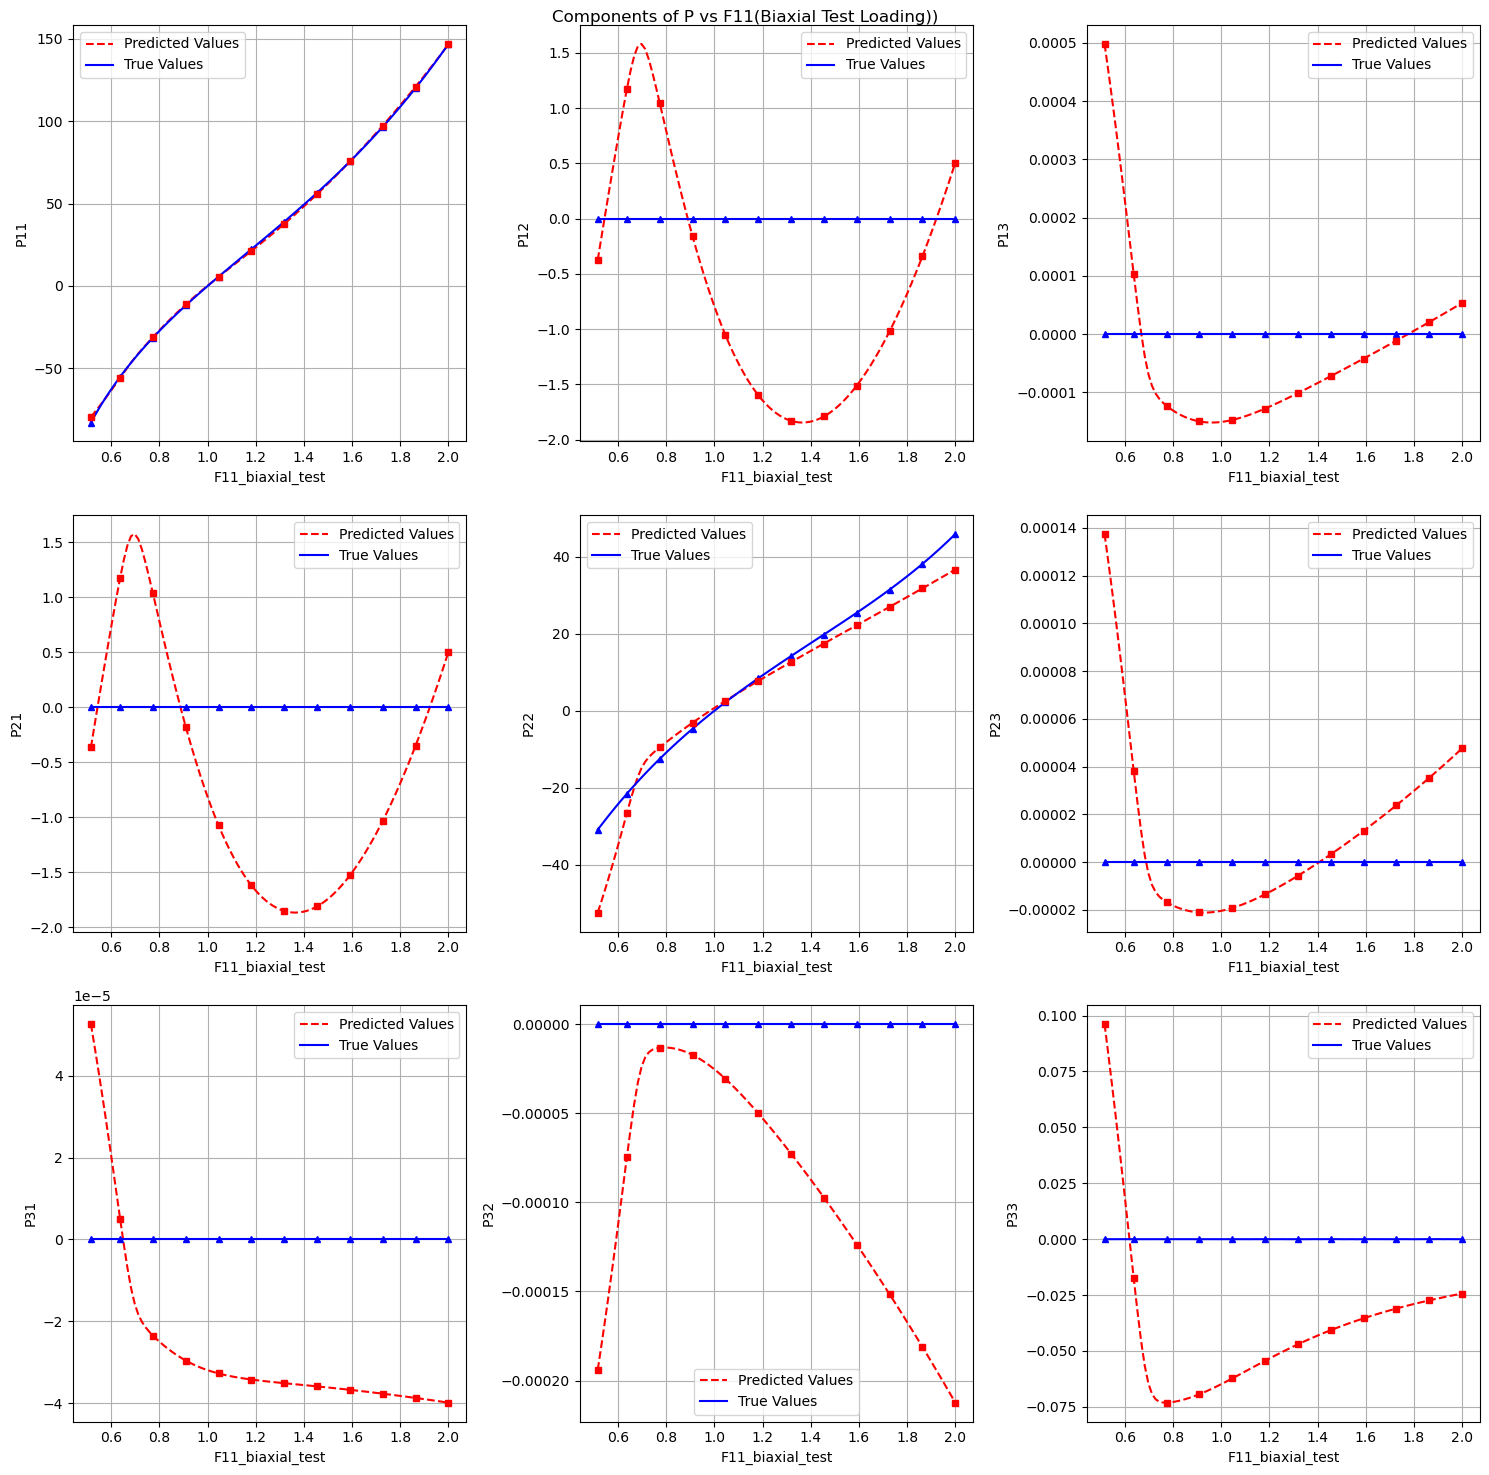

In [53]:
import matplotlib.pyplot as plt
import numpy as np

F11_biaxial_test = F_biaxial_test[:, 0, 0]
C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))

P_biaxial_test_pred = model1.predict(C_biaxial_test)
P_biaxial_test_pred = P_biaxial_test_pred.reshape(-1, 3, 3)
P_biaxial_test = P_biaxial_test.reshape(-1, 3, 3)

# Select 12 evenly spaced indices
total_points = len(F11_biaxial_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11(Biaxial Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_biaxial_test, P_biaxial_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_biaxial_test, P_biaxial_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_biaxial_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


4/4 [==============================] - 0s 1ms/step


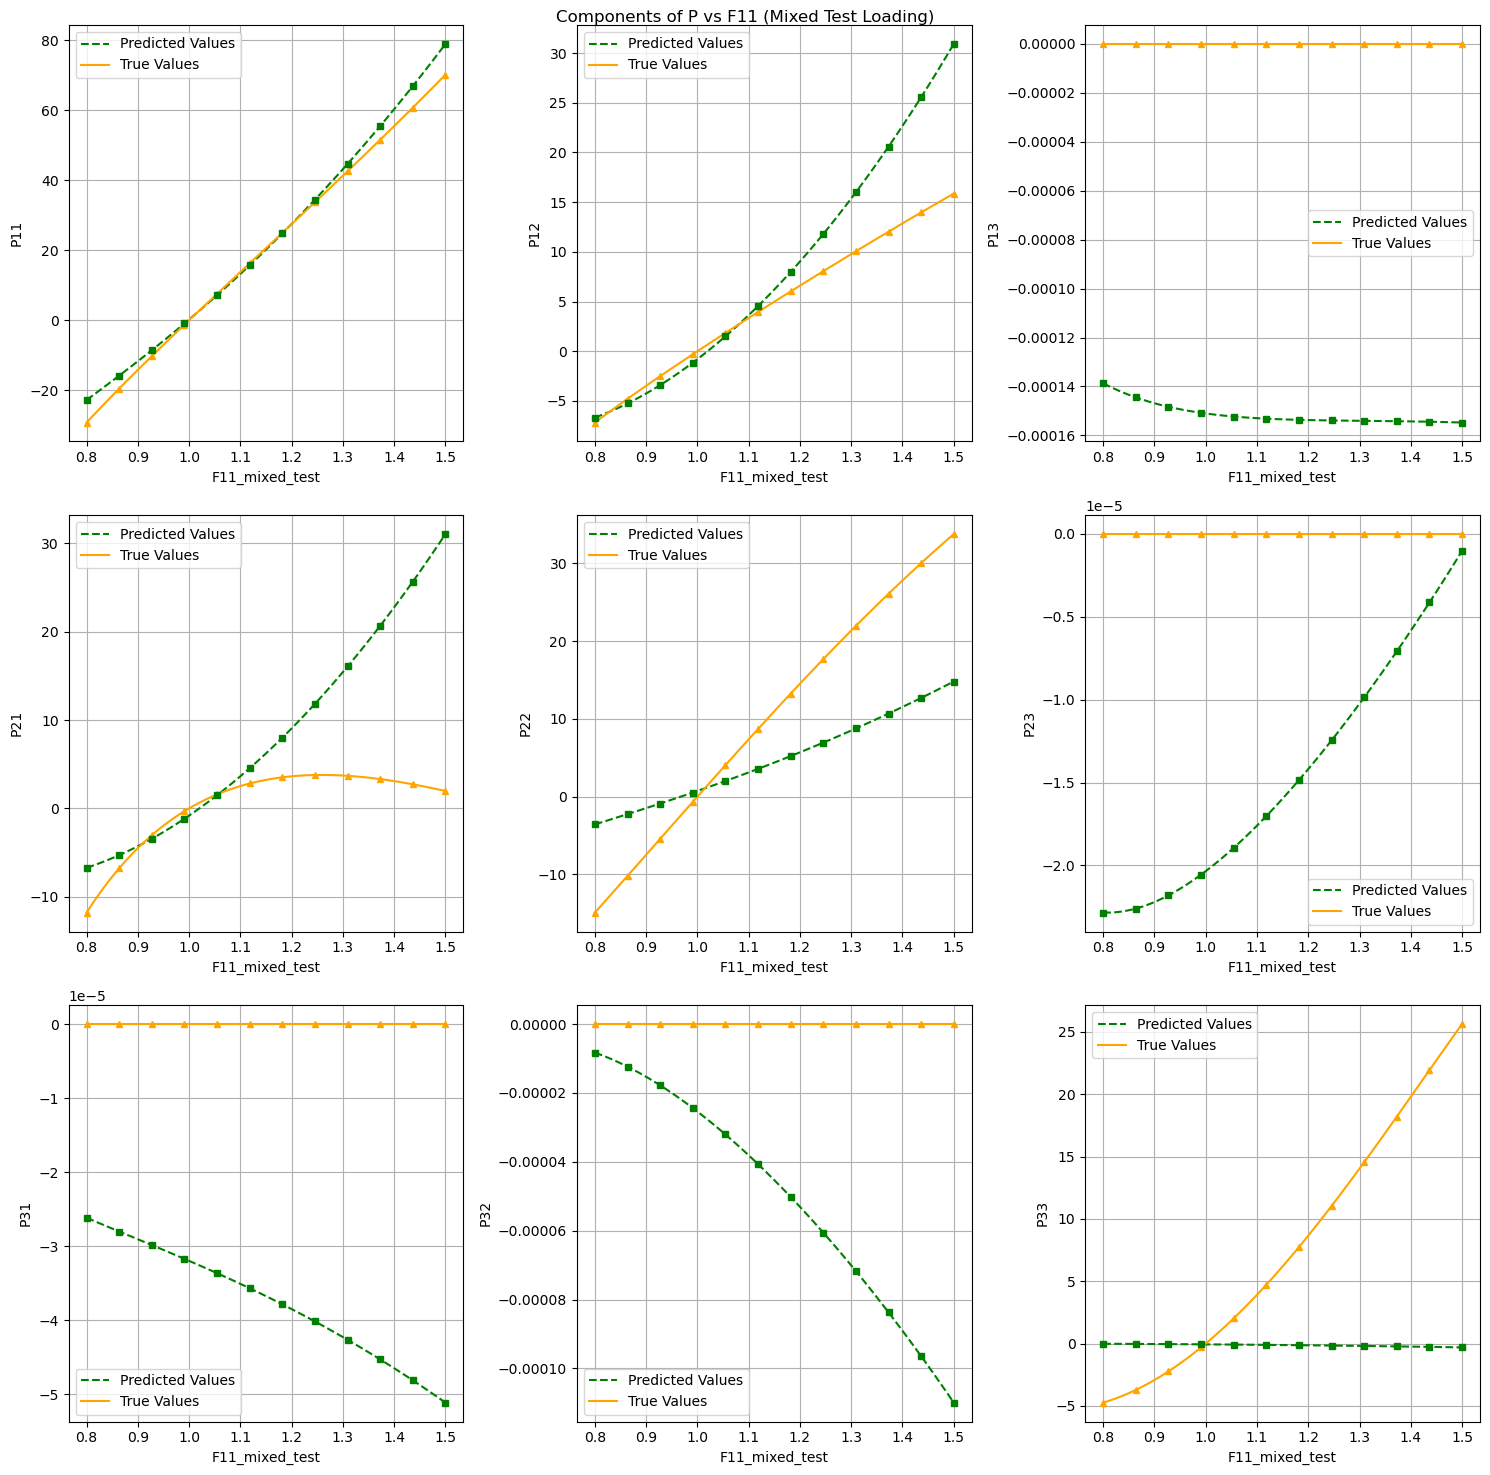

In [54]:
# 假设 F_mixed_test 和 P_mixed_test_pred 已经定义，F_mixed_test 的形状是 (N, 3, 3)

F11_mixed_test = F_mixed_test[:, 0, 0]  # 获取 F11 数据
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))  # 已经计算的右 Cauchy-Green 张量

P_mixed_test_pred = model1.predict(C_mixed_test)  # 预测的 P 张量
P_mixed_test_pred = P_mixed_test_pred.reshape(-1, 3, 3)  # 重新调整为 (N, 3, 3)
P_mixed_test = P_mixed_test.reshape(-1, 3, 3)  # 已知的真实值

# Select 12 evenly spaced indices
total_points_mixed = len(F11_mixed_test)
indices_mixed = np.linspace(0, total_points_mixed-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 (Mixed Test Loading)')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_mixed_test, P_mixed_test_pred[:, i, j], 'g--', label='Predicted Values')
        # Plot the continuous true values with solid orange line
        axs[index].plot(F11_mixed_test, P_mixed_test[:, i, j], 'orange', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test[indices_mixed, i, j], 'orange', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test_pred[indices_mixed, i, j], 'g', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_mixed_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


### Loss weighting strategy

In [55]:
model2 = lm.main()


model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p_2 (_C_to_P)  (None, 9)                 93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [56]:
print(P_biaxial.shape)

(199, 3, 3)


In [57]:
import numpy as np



def calculate_path_weight(P_values):
   
    norm = np.linalg.norm(P_values,'fro', axis=(1, 2)).mean()
    return 1 / norm  


weight_biaxial = calculate_path_weight(P_biaxial)
weight_pure_shear = calculate_path_weight(P_pure_shear)
weight_uniaxial = calculate_path_weight(P_uniaxial)


sample_weights = np.concatenate([
    np.full(P_biaxial.shape[0], weight_biaxial),      
    np.full(P_pure_shear.shape[0], weight_pure_shear), 
    np.full(P_uniaxial.shape[0], weight_uniaxial)     
])

#sample_weights /= np.sum(sample_weights)


print("Sample weights:", sample_weights)
print("Sum of sample weights:", np.sum(sample_weights))

Sample weights: [0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0

In [58]:
print("weight_biaxial:", weight_biaxial)
print("weight_pure_shear:", weight_pure_shear)
print("weight_uniaxial:", weight_uniaxial)

weight_biaxial: 0.014009094220516313
weight_pure_shear: 0.03335082320164705
weight_uniaxial: 0.019330317859574873


In [59]:
P_list = [
    tf.convert_to_tensor(P_uniaxial, dtype=tf.float32),
    tf.convert_to_tensor(P_biaxial, dtype=tf.float32),
    tf.convert_to_tensor(P_pure_shear, dtype=tf.float32)
]


In [60]:
def calc_weights(P_list):
    # 计算每个路径的范数均值并取倒数作为权重
    norm_P_uniax = tf.norm(P_list[0], ord='fro', axis=[1, 2])
    weights_uniax_mean = tf.math.reduce_mean(norm_P_uniax)
    weights_uniax = 1 / weights_uniax_mean
    weights_uniax_norm = weights_uniax

    norm_P_biax = tf.norm(P_list[1], ord='fro', axis=[1, 2])
    weights_biax_mean = tf.math.reduce_mean(norm_P_biax)
    weights_biax = 1 / weights_biax_mean
    weights_biax_norm = weights_biax

    norm_P_shear = tf.norm(P_list[2], ord='fro', axis=[1, 2])
    weights_shear_mean = tf.math.reduce_mean(norm_P_shear)
    weights_shear = 1 / weights_shear_mean
    weights_shear_norm = weights_shear

    # 创建对应长度的权重张量并应用归一化因子
    w_uniax = tf.ones([199,]) * weights_uniax_norm
    w_biax = tf.ones([199,]) * weights_biax_norm
    w_shear = tf.ones([250,]) * weights_shear_norm

    # 拼接所有权重
    
    weights = tf.concat([w_uniax, w_biax, w_shear], axis=0)

    return weights

weights = calc_weights(P_list)

In [61]:
first_199 = tf.reduce_sum(weights[:199])
middle_199 = tf.reduce_sum(weights[199:398])  # from index 199 to 398
last_250 = tf.reduce_sum(weights[398:])  # from index 398 to end

print("Sum of first 199 weights (uniaxial):", first_199.numpy())
print("Sum of middle 199 weights (biaxial):", middle_199.numpy())
print("Sum of last 250 weights (shear):", last_250.numpy())

print("each of first 199 weights (uniaxial):", first_199.numpy()/199)
print("each of middle 199 weights (biaxial):", middle_199.numpy()/199)
print("each of last 250 weights (shear):", last_250.numpy()/250)

Sum of first 199 weights (uniaxial): 3.846734
Sum of middle 199 weights (biaxial): 2.7878096
Sum of last 250 weights (shear): 8.337705
each of first 199 weights (uniaxial): 0.019330321843899673
each of middle 199 weights (biaxial): 0.014009093519431262
each of last 250 weights (shear): 0.033350818634033205


In [62]:
sum_first_216 = np.sum(sample_weights[:199])
sum_middle_216 = np.sum(sample_weights[199:449])
sum_last_216 = np.sum(sample_weights[449:])

print("first:", sum_first_216)
print("seconde:", sum_middle_216)
print("thrid:", sum_last_216)


first: 2.7878097498827463
seconde: 8.337705800411763
thrid: 3.8467332540554002


In [63]:
C_train = convert_F_to_C(F_train)

Epoch 1/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 2/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 3/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 4/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0246
Epoch 5/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0246
Epoch 6/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 7/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 8/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 9/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 10/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 11/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 12/10000
21/21 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 13/1000

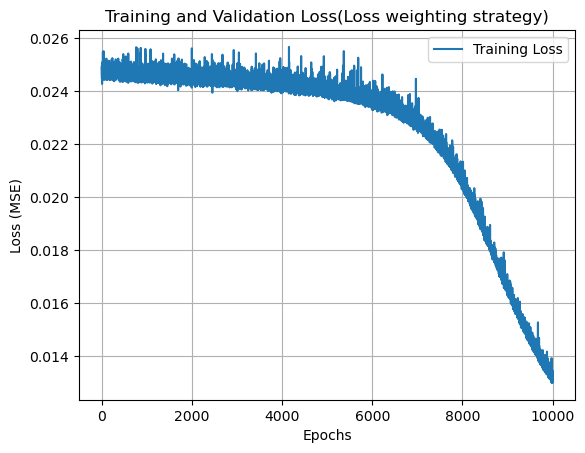

In [68]:
# 训练模型
history = model2.fit(C_train, P_train, epochs=10000, sample_weight=sample_weights)

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss(Loss weighting strategy)")
plt.grid(True)
plt.show()

4/4 [==============================] - 0s 1ms/step


C:\Users\10472\AppData\Local\Temp\ipykernel_29080\1356739176.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^',


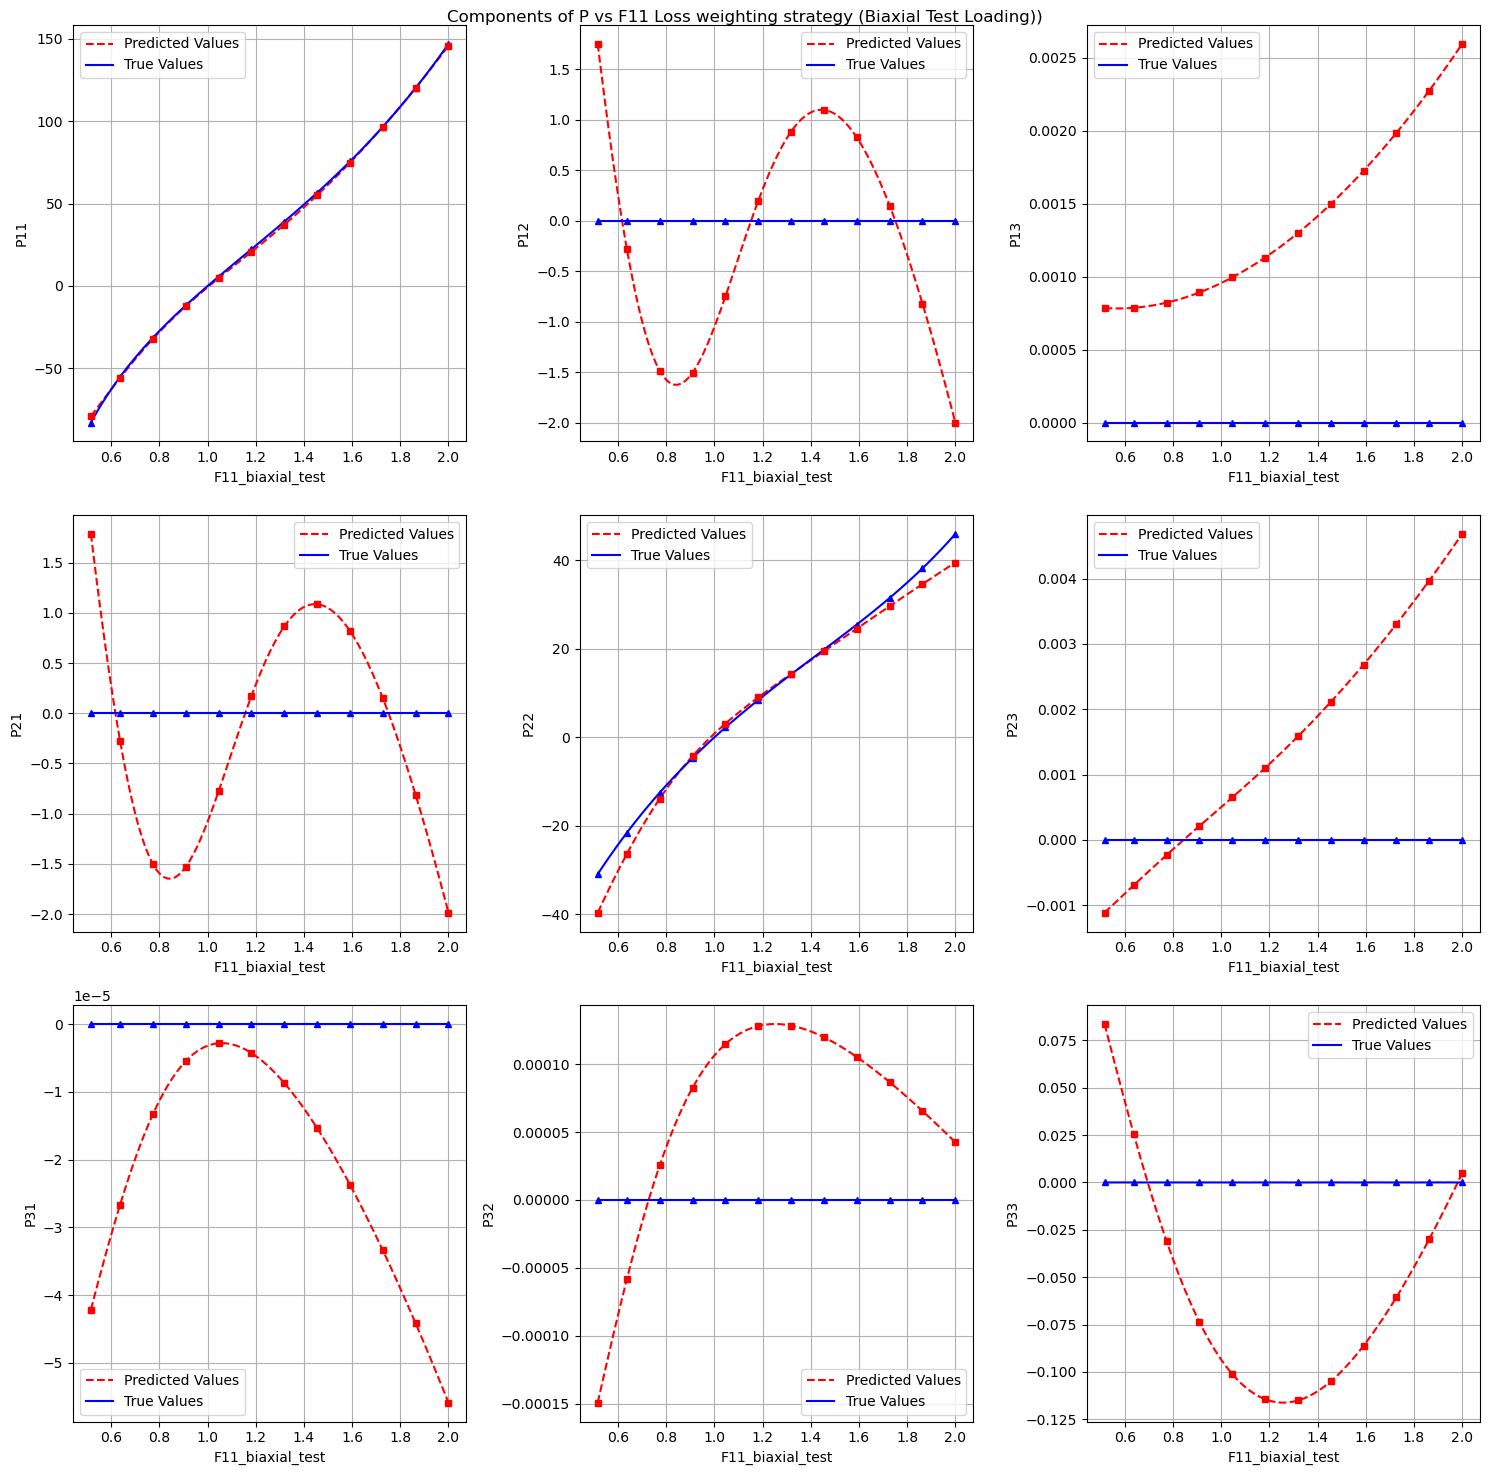

In [69]:
import matplotlib.pyplot as plt
import numpy as np

F11_biaxial_test = F_biaxial_test[:, 0, 0]
C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))

P_biaxial_test_pred = model2.predict(C_biaxial_test)
P_biaxial_test_pred = P_biaxial_test_pred.reshape(-1, 3, 3)
P_biaxial_test = P_biaxial_test.reshape(-1, 3, 3)

# Select 12 evenly spaced indices
total_points = len(F11_biaxial_test)
indices = np.linspace(0, total_points-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Loss weighting strategy (Biaxial Test Loading))')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_biaxial_test, P_biaxial_test_pred[:, i, j], 'r--', label='Predicted Values')
        # Plot the continuous true values with solid blue line
        axs[index].plot(F11_biaxial_test, P_biaxial_test[:, i, j], 'b-', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test[indices, i, j], 'b-', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_biaxial_test[indices], P_biaxial_test_pred[indices, i, j], 'r', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_biaxial_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()


4/4 [==============================] - 0s 1ms/step


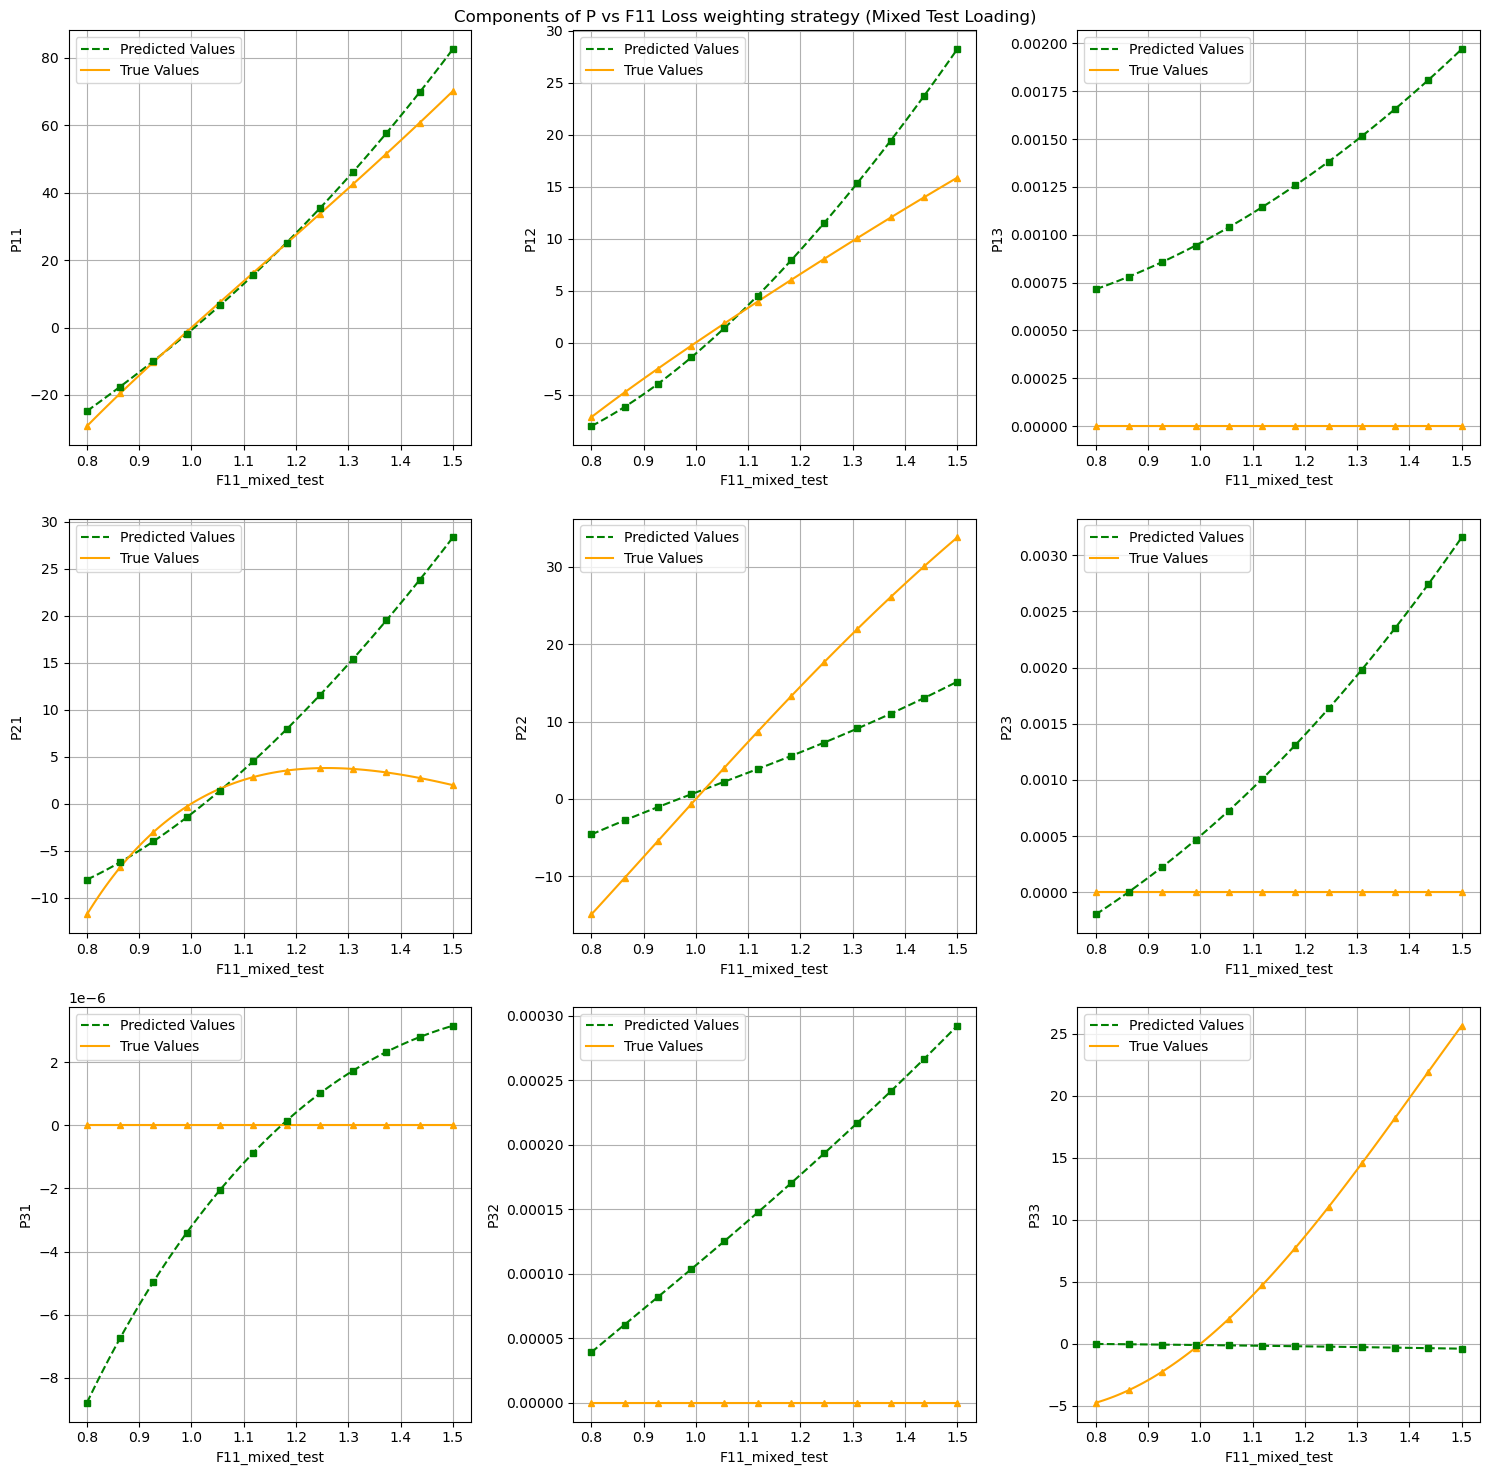

In [71]:
# 假设 F_mixed_test 和 P_mixed_test_pred 已经定义，F_mixed_test 的形状是 (N, 3, 3)

F11_mixed_test = F_mixed_test[:, 0, 0]  # 获取 F11 数据
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))  # 已经计算的右 Cauchy-Green 张量

P_mixed_test_pred = model2.predict(C_mixed_test)  # 预测的 P 张量
P_mixed_test_pred = P_mixed_test_pred.reshape(-1, 3, 3)  # 重新调整为 (N, 3, 3)
P_mixed_test = P_mixed_test.reshape(-1, 3, 3)  # 已知的真实值

# Select 12 evenly spaced indices
total_points_mixed = len(F11_mixed_test)
indices_mixed = np.linspace(0, total_points_mixed-1, 12, dtype=int)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Components of P vs F11 Loss weighting strategy (Mixed Test Loading)')

# Flatten the axs array for easier iteration
axs = axs.flatten()

# For each component of P (assuming P has 9 components)
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        # Plot the continuous predicted values with dashed line
        axs[index].plot(F11_mixed_test, P_mixed_test_pred[:, i, j], 'g--', label='Predicted Values')
        # Plot the continuous true values with solid orange line
        axs[index].plot(F11_mixed_test, P_mixed_test[:, i, j], 'orange', label='True Values')
        
        # Plot only 12 points for the true values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test[indices_mixed, i, j], 'orange', marker='^', 
                        markersize=4, linestyle='none')
        
        # Plot only 12 points for the predicted values
        axs[index].plot(F11_mixed_test[indices_mixed], P_mixed_test_pred[indices_mixed, i, j], 'g', marker='s', 
                        markersize=4, linestyle='none')
        
        axs[index].set_xlabel('F11_mixed_test')
        axs[index].set_ylabel(f'P{i+1}{j+1}')
        axs[index].legend()
        axs[index].grid(True)

plt.tight_layout()
plt.show()
